In [1]:
# 필요한 라이브러리 불러오기.
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 대이터를 로드할 때 빠르게 로드할 수 있도록하는 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X_RAY 이미지 사이즈 변수
image_size = [180, 180]

# 데이터 경로 변수
root_path = os.path.join(os.getenv('HOME'), 'aiffel')

# *은 모든 디렉토리와 파일을 의미합니다.
train_path = root_path + '/chest_xray/data/train/*/*' 
val_path = root_path + '/chest_xray/data/val/*/*'
test_path = root_path + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경하기.
batch_size = 16
epochs = 10

print(root_path)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(train_path)
test_filenames = tf.io.gfile.glob(test_path)
val_filenames = tf.io.gfile.glob(val_path)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train : 5216
- test : 624
- val : 16  
val의 개수가 너무 없기 때문에 traindptj val에 쓸 데이터를 가져옴  
train과 val에 있는 데이터를 모은다음 train : val = 80 : 20 으로 분활

In [4]:
# 모았다가 다시 나누기.
# train 데이터와 validation 데이터를 모두 filenames에 담음
filenames = tf.io.gfile.glob(train_path)
filenames.extend(tf.io.gfile.glob(val_path))

# 모아진 filenames 를 80 : 20으로 나눔.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)

train_filenames = filenames[:train_size]
val_filenames = filenames[train_size :]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train 데이터 안에 정상 이미지 수와 폐렴 이미지수를 확인.
- 먼저 정상 이미지, 폐렴 이미지의 파일 경로 확인

In [5]:
# 정상, 폐렴 각 이미지들의 파일 경로 확인.
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


- fileanmes에 train, val 데이터를 합쳤기 때문에  
filenames 첫단에는 Normal이, 끝단에는 Pneumonia이다.

In [6]:
# 정상, 폐렴이미지의 수 확인
count_normal = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f'Normal images count in training set : {count_normal}')

count_pneumonia = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f'Pneumonia images count in training set : {count_pneumonia}')

Normal images count in training set : 1072
Pneumonia images count in training set : 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train, Validation 데이터셋 개수 확인
train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training image count ; {train_img_count}')

val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validatingimages count : {val_img_count}')

Training image count ; 4185
Validatingimages count : 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성으로 구분 가능.
def get_label(file_path) :
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

#  페렴이면 True(양성), 정상이면 False(음성)

In [10]:
#  이미지를 알맞은 형식으로 바꿈.
def decode_img(img) :                                    
    img = tf.image.decode_jpeg(img, channels = 3)         # 이미지를 uint8 tensor로 수정 
    img = tf.image.convert_image_dtype(img, tf.float32)   # float32 타입으로 수정
    img = tf.image.resize(img, image_size)                # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path) :
    label = get_label(file_path)         # 라벨 검출
    img = tf.io.read_file(file_path)     # 이미지 읽기
    img = decode_img(img)                # 이미지를 알맏은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [12]:
# 라벨이 잘 들어갔는지 확인.
for image, label in train_ds.take(1) :    # 데이터 하나만 가져오라는 의미.
    print('Image shape :', image.numpy().shape)
    print('Label :', label.numpy())

Image shape : (180, 180, 3)
Label : False


In [13]:
test_list_ds = tf.data.Dataset.list_files(test_path)
test_image_count = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(batch_size)

print(test_image_count)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size = 1000) :
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

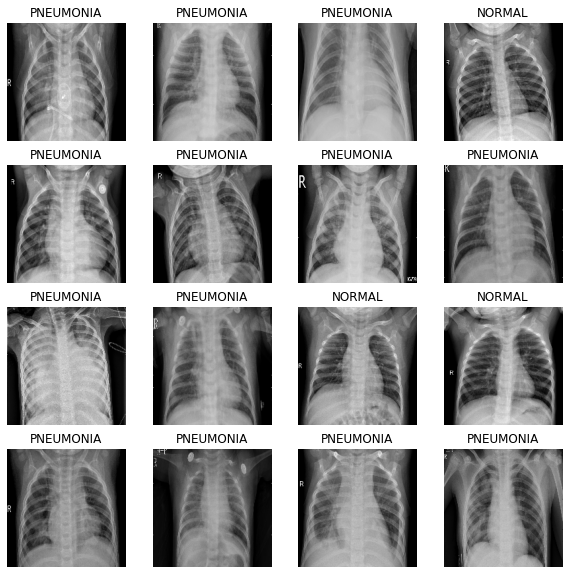

In [15]:
# 시각화

# 이미지 배치를 입력하면 여러장의 이미지를 보여준다.
def show_batch(image_batch, label_batch) :
    plt.figure(figsize = (10, 10))
    for n in range(batch_size) :
        ax = plt.subplot(4, math.ceil(batch_size/4), n+1)
        plt.imshow(image_batch[n])
        
        if label_batch[n] :
            plt.title('PNEUMONIA')
        else :
            plt.title('NORMAL')
        plt.axis('off')
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
# CNN 모델링

def conv_block(filters) :
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,
                                       3,
                                       activation = 'relu',
                                       padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters,
                                       3,
                                       activation = 'relu',
                                       padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# dense block 만들기
def dense_block(units, dropout_rate) :
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units,
                             activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
# 모델 빌드 (함수 만들어 놓기.)

def build_model() :
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (image_size[0], image_size[1], 3)),
        
        tf.keras.layers.Conv2D(16,
                              3,
                              activation = 'relu',
                              padding = 'same'),
        tf.keras.layers.Conv2D(16,
                              3,
                              activation = 'relu',
                              padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1,
                             activation = 'sigmoid')
    ])
    
    return model

In [19]:
# 사용할 Weight 세팅
weight_for_0 = (1 / count_normal) * (train_img_count) / 2.0
weight_for_1 = (1 / count_pneumonia) * (train_img_count) / 2.0

class_weight = {0 : weight_for_0, 1 : weight_for_1}

print('Weight for NORMAL : {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA : {:.2f}'.format(weight_for_1))

Weight for NORMAL : 1.95
Weight for PNEUMONIA : 0.67


In [20]:
# 모델 훈련
with tf.device('/GPU:0') :
    model = build_model()
    
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = metrics
    )

In [21]:
# 모델 적용 학습 시키기.
with tf.device('/GPU:0') :
    history = model.fit( 
        train_ds,
        steps_per_epoch = train_img_count // batch_size,
        epochs = epochs,
        validation_data = val_ds,
        validation_steps = val_img_count // batch_size,
        class_weight = class_weight,)

Epoch 1/10
261/261 [==============================] - 148s 447ms/step - loss: 0.3804 - accuracy: 0.8187 - precision: 0.9600 - recall: 0.7891 - val_loss: 0.6298 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 105s 402ms/step - loss: 0.2475 - accuracy: 0.9057 - precision: 0.9695 - recall: 0.9014 - val_loss: 1.1079 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 108s 414ms/step - loss: 0.1767 - accuracy: 0.9373 - precision: 0.9798 - recall: 0.9350 - val_loss: 0.1551 - val_accuracy: 0.9298 - val_precision: 0.9148 - val_recall: 0.9974
Epoch 4/10
261/261 [==============================] - 112s 430ms/step - loss: 0.1625 - accuracy: 0.9358 - precision: 0.9823 - recall: 0.9304 - val_loss: 0.2206 - val_accuracy: 0.9356 - val_precision: 0.9957 - val_recall: 0.9163
Epoch 5/10
261/261 [==============================] - 119s 456ms/step - loss: 0.1648 - a

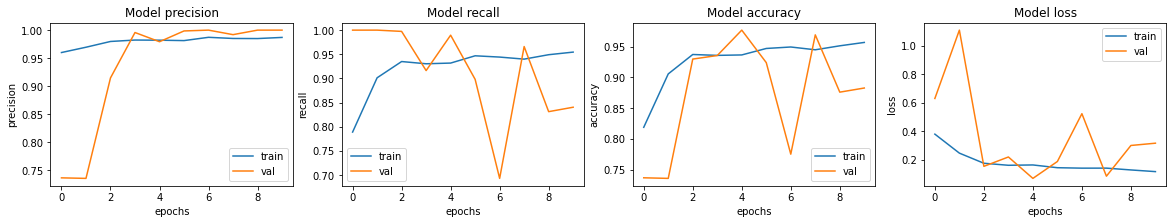

In [24]:
# 결과 확인 하기.
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']) :
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss:[loss], \nAccuracy: {accuracu}, \nPrecision: {precision}, \nRecall: {recall}')

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)